# 2024 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
Before running the cells, make sure you have the required packages given in `requirement.txt` file installed in your system.

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
!pip install contractions
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.9 MB/s eta 0:00:00


## Mount Google Drive and Load Dataset
The datasets are available on Google Drive, so we will mount it and load the datasets from there.

In [ ]:
# Mounting Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Changing the current directory to the project folder in Google Drive
import os
os.chdir('/content/drive/MyDrive/COMP90042_Project')

Mounted at /content/drive


In [ ]:
import json

def load_data(file_path):
    """
    Loads data from a JSON file.

    Args:
    file_path (str): Path to the JSON file.

    Returns:
    dict: Loaded data.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [ ]:
# Load data
train_claims = load_data('data/train-claims.json')
dev_claims = load_data('data/dev-claims.json')
test_claims = load_data('data/test-claims-unlabelled.json')
evidence = load_data('data/evidence.json')

## Data Preprocessing Steps

Now that we have loaded all the datasets required for the project, we need to preprocess them to ensure they are appropriate for the tasks at hand.

The preprocessing steps done are described within each function block below.

In [ ]:
import string
from tqdm import tqdm
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Downloads NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We will perform basic preprocessing on the datasets, including contraction replacement, word tokenization, lemmatization, punctuation removal, and padding.

Although normally we would remove stopwords, we are not doing that here as some of the stopwords are important during classification task (eg. "not", "didn't" etc as they may decide if the evidences support or refute the claim).

In [ ]:
def preprocess_text(text):
    """
    Preprocesses text by contraction replacement, tokenization, lemmatization, stopwords removal, and punctuation removal.

    Args:
    text (str): Input text.

    Returns:
    str: Preprocessed text.
    """
    # Convert to lowercase
    text = text.lower()
    # Replace contractions
    text = contractions.fix(text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


def prepare_sequences(texts, tokenizer, max_length):
    """
    Tokenizes and pads sequences.

    Args:
    texts (list): List of texts.
    tokenizer: Keras tokenizer.
    max_length (int): Maximum sequence length.

    Returns:
    numpy.ndarray: Padded sequences.
    """
    # Tokenize texts
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    return padded_sequences

Let's run the preprocessing steps on our datasets.

In [ ]:
# Preprocess claim texts
for i, dataset in enumerate([train_claims, dev_claims, test_claims]):
    for claim_id, claim_data in tqdm(dataset.items(), desc=f'Processing claim set {i}'):
        dataset[claim_id]['claim_text'] = preprocess_text(claim_data['claim_text'])

# Preprocess evidence texts
for evidence_id, evidence_text in tqdm(evidence.items(), desc='Processing evidences'):
    evidence[evidence_id] = preprocess_text(evidence_text)

Processing evidences: 100%|██████████| 1208827/1208827 [11:57<00:00, 1685.66it/s]


Next, we will use the Keras Tokeniser to tokenise our preprocessed texts into integer vectors and pad them to sequences of uniform length to ensure that they can be properly fed into neural networks later.

We will also calculate the vocabulary size here for use in model building later.

In [ ]:
# Combine all claim texts and evidence texts
all_texts = [claim_data['claim_text'] for dataset in (train_claims, dev_claims, test_claims) for claim_id, claim_data in dataset.items()]
all_texts += list(evidence.values())

# Tokenize all texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)

# Define maximum sequence length
max_length = 20

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Prepare sequences for claims and evidence
for i, dataset in enumerate([train_claims, dev_claims, test_claims]):
    for claim_id, claim_data in tqdm(dataset.items(), desc=f'Processing claim set {i}'):
        claim_text = claim_data['claim_text']
        dataset[claim_id]['padded_sequence'] = prepare_sequences([claim_text], tokenizer, max_length)[0]

for evidence_id, evidence_text in tqdm(evidence.items(), desc='Processing evidences'):
    evidence[evidence_id] = {
        'evidence_text': evidence_text,
        'padded_sequence': prepare_sequences([evidence_text], tokenizer, max_length)[0]
    }

Processing evidences: 100%|██████████| 1208827/1208827 [00:56<00:00, 21360.51it/s]


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Evidence Retrieval Task

Now we wish to perform the following task: for each claim we want to predict relevant evidences based on similarity scores.

For this we will use a Siamese architecture with bidirectional LSTM and cosine similarity score.

### Prepare Training Data
First, we will prepare the training data into an appropriate format.

For each claim, we will have multiple evidences, and a label (1=relevant, 0=irrelevant). Since the evidence contains more than a million elements, we will only have a fixed number of evidences per claim.

So for each claim, we will have all the relevant evidences and a number of random irrelevant evidences, such that the total number of evidences used per claim is:

$\min(\text{number of available evidences}, \max(2⋅\text{number of relevant evidences}, n))$

to ensure $\text{number of irrelevant evidences}\geq\text{number of relevant evidences}$ in most cases such that the $\text{number of evidences per claim}\leq\text{number of available evidences}$.

In [ ]:
import numpy as np

# Prepare training data function
def prepare_siamese_training_data(claims_data, evidence_data, n=100):
    """
    Prepares training data for Siamese network training.

    Args:
    claims_data (dict): Dictionary containing claim data.
    evidence_data (dict): Dictionary containing evidence data.
    n (int): Total number of evidences to use per claim. Defaults to 100.

    Returns:
    tuple: Tuple containing claim sequences, evidence sequences, and labels.
    """
    claim_sequences = []
    evidence_sequences = []
    labels = []

    # Calculate the number of available evidences and retrieve all evidence ids
    all_evidence_id = evidence_data.keys()
    available_evidences = len(all_evidence_id)

    # Iterate over claims data
    for claim_id, claim_info in tqdm(claims_data.items(), desc='Processing training data'):
        claim_sequence = claim_info['padded_sequence']
        relevant_evidences = claim_info['evidences']
        num_relevant_evidences = len(relevant_evidences)

        # Iterate over relevant evidences
        for evidence_id in relevant_evidences:
            evidence_sequence = evidence_data[evidence_id]['padded_sequence']
            claim_sequences.append(claim_sequence)
            evidence_sequences.append(evidence_sequence)
            labels.append(1) # Relevant evidence

        # Calculate how many irrelevant evidences required
        total_evidences_needed = min(available_evidences, max(2 * num_relevant_evidences, n))
        irrelevant_evidences_needed = total_evidences_needed - num_relevant_evidences

        # Find the list of irrelevant evidences
        irrelevant_evidences = list(set(all_evidence_id).difference(set(relevant_evidences)))

        # Randomly choose required number of irrelvant evidence ids (without replacement)
        chosen_irrelevant_evidences = np.random.choice(irrelevant_evidences, size=irrelevant_evidences_needed, replace=False)

        # Iterate over irrelevant evidences
        for evidence_id in chosen_irrelevant_evidences:
            evidence_sequence = evidence_data[evidence_id]['padded_sequence']
            claim_sequences.append(claim_sequence)
            evidence_sequences.append(evidence_sequence)
            labels.append(0) # Irrelevant evidence

    claim_sequences = np.array(claim_sequences)
    evidence_sequences = np.array(evidence_sequences)
    labels = np.array(labels, dtype='float32')

    return claim_sequences, evidence_sequences, labels

In [ ]:
# Set the number of evidences to use per claim
num_evidences = 40

# Prepare training data
train_claim_sequence, train_evidence_sequence, train_labels = prepare_siamese_training_data(train_claims, evidence, n=num_evidences)

Processing training data: 100%|██████████| 1228/1228 [21:48<00:00,  1.07s/it]


### Siamese Model
The Siamese architecture is a neural network design used for comparing pairs of inputs. In claim-evidence relevance prediction, it compares a claim with multiple evidence items to determine which evidence is relevant. The shared representation learning in Siamese networks allows for efficient pairwise comparison and capturing of semantic similarities between claims and evidence. This architecture is chosen for its ability to handle pairwise comparisons effectively and learn meaningful representations of claims and evidence items, leading to accurate relevance predictions.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dot, Concatenate, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model

# Define Siamese network architecture
def build_siamese_network(max_length, vocab_size, embedding_dim=128, lstm_units=64):
    """
    Constructs a Siamese network with Bidirectional LSTM for relevance prediction.

    Args:
    max_length (int): Maximum sequence length.
    vocab_size (int): Vocabulary size.
    embedding_dim (int): Dimensionality of the embedding space. Defaults to 128.
    lstm_units (int): Number of LSTM units. Defaults to 64.

    Returns:
    tensorflow.keras.models.Model: Siamese network model.
    """
    # Input layer
    input_claim = Input(shape=(max_length,), name='input_claim')
    input_evidence = Input(shape=(max_length,), name='input_evidence')

    # Embedding layer; mask_zero=True to skip the extra padding tokens
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, mask_zero=True)

    # Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(units=lstm_units, activation="relu", return_sequences=True))

    # Claim branch
    claim_embedded = embedding_layer(input_claim)
    claim_encoded = lstm_layer(claim_embedded)

    # Evidence branch
    evidence_embedded = embedding_layer(input_evidence)
    evidence_encoded = lstm_layer(evidence_embedded)

    # Similarity calculation using dot product wih normalization (cosine similarity)
    similarity = Dot(axes=-1, normalize=True)([claim_encoded, evidence_encoded])

    # Concatenate claim and evidence encodings
    merged = Concatenate(axis=-1)([claim_encoded, evidence_encoded, similarity])

    # Add dense layers with dropout and BatchNormalisation
    hidden_1 = Dense(units=128, activation="relu")(merged)
    hidden_1 = Dropout(0.2)(hidden_1)

    normal_1 = BatchNormalization()(hidden_1)

    hidden_2 = Dense(units=128, activation="relu")(normal_1)
    hidden_2 = Dropout(0.2)(hidden_2)

    normal_2 = BatchNormalization()(hidden_2)

    # Flatten the layer into 1D tensor
    flatten = Flatten()(normal_2)

    # Output layer for classification
    output = Dense(units=1, activation='sigmoid')(flatten)

    # Model definition
    model = Model(inputs=[input_claim, input_evidence], outputs=output)

    return model

### Contrastive Loss
For the loss function of the Siamese model, we will use a custom contrastive loss. The contrastive loss function is commonly used in Siamese networks and related architectures for tasks such as text similarity, image similarity, and more. It encourages the model to learn embeddings that map similar text inputs closer together while pushing dissimilar pairs apart by a specified margin. Mathematically, it penalizes the model based on the discrepancy between predicted and true labels, promoting discriminative embeddings.

**Mathematical expression:**

$L(y, \hat{y}) = \frac{1}{2N} \sum_{i=1}^{N} y_i \cdot d_i^2 + (1 - y_i) \cdot \max(margin - d_i, 0)^2$

Where:
- $y_i$ represents the true label for the pair of inputs, indicating similarity (1) or dissimilarity (0).
- $\hat{y}_i$ is the predicted output (distance or dissimilarity) for the pair of inputs.
- $d_i$ denotes the distance or dissimilarity between the embeddings of the input pair.
- $N$ is the total number of input pairs.

In [ ]:
def loss(margin=1):
    """
    Creates a contrastive loss function with a specified margin.

    Parameters:
        margin (float): The margin parameter for the contrastive loss function. Defaults to 1.

    Returns:
        function: A TensorFlow function representing the contrastive loss.
    """
    def contrastive_loss(y_true, y_pred):
        """
        Computes the contrastive loss between the true labels and predicted probabilities.

        Parameters:
            y_true (tensor): True labels (0 for irrelevant pairs, 1 for relevant pairs).
            y_pred (tensor): Predicted probabilities.

        Returns:
            tensor: The contrastive loss value.
        """
        # Ensure inputs are in float32
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        # Compute square of predicted probabilities
        square_pred = tf.math.square(y_pred)

        # Compute hinge loss component
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))

        # Compute contrastive loss as a combination of squared loss and hinge loss
        con_loss = tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return con_loss

    return contrastive_loss

### Cyclical Learning Rate (Triangle2)
Given the size of the training dataset we will use for the project, it is expected to take a very long time for the Siamese model to converge using fixed learning rates. Hence, we opted for using cyclical learning rate that is known for its ability of super convergence.

Cyclical learning rates, such as the triangle2 policy, involve cyclically increasing and decreasing the learning rate within a specified range during training. Here's how it works:

1. Initialization: Define an initial learning rate (base_lr) and a maximum learning rate (max_lr). These values determine the lower and upper bounds of the learning rate range.

2. Cyclic Variation: During training, the learning rate oscillates between base_lr and max_lr following a triangular waveform pattern.

3. Triangular Pattern: The learning rate starts at base_lr and linearly increases to max_lr over a certain number of iterations (called the step size). This phase is known as the "increase" phase.

4. Decrease Phase: After reaching max_lr, the learning rate linearly decreases back to base_lr over the remaining iterations.

5. Cycle Completion: This process forms a complete cycle of learning rate variation. In every subsequent cycle, the "triangular2" policy cuts the max learning rate bound in half. This allows to oscillate our learning rate to break out of saddle points/local minima and at the same time decrease our learning rate, enabling us to descend into lower loss areas of the loss landscape. Multiple cycles can be performed during training to explore different regions of the loss landscape.

Key Aspects:

- Dynamic Adjustment: The learning rate dynamically adjusts within the specified range, allowing the model to explore a broader range of solutions.

- Accelerated Convergence: The cyclic variation helps in escaping sharp minima and accelerating convergence towards potentially better solutions.

- Regularization Effect: The cyclical nature of learning rates can act as a form of regularization, enhancing the model's generalization capability.




In [ ]:
from tensorflow_addons.optimizers import CyclicalLearningRate

def make_cyclical_lr(train_seq_length, batch_size, base_lr=1e-4, max_lr=1e-2):
    """
    Creates a CyclicalLearningRate object for implementing cyclical learning rate policy.

    Args:
    train_seq_length (int): Total length of the training dataset.
    batch_size (int): Size of each training batch.
    base_lr (float): Initial learning rate at the start of the cycle. Defaults to 1e-4.
    max_lr (float): Maximum learning rate achieved during the cycle. Defaults to 1e-2.

    Returns:
    tensorflow_addons.optimizers.CyclicalLearningRate: CyclicalLearningRate object.
    """
    # Calculate the number of steps (batches) per epoch
    steps_per_epoch = train_seq_length // batch_size

    # Define the CyclicalLearningRate object with the specified parameters
    clr = CyclicalLearningRate(
        initial_learning_rate = base_lr,
        maximal_learning_rate = max_lr,
        scale_fn = lambda x: 1 / (2.**(x - 1)),  # Triangular2 scale function
        step_size = 3 * steps_per_epoch  # Total steps per cycle (3 full epochs)
    )

    return clr

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Model Compilation
Now that we have defined the architecture of the neural network, the loss function, and the learning rate scheduler it is time to compile the model and train it on our dataset.

Let's build the model using custom hyperparameters and compile it. We will also use eraly stopping to prevent overfitting.

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_claim (InputLayer)    [(None, 20)]                 0         []                            
                                                                                                  
 input_evidence (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 embedding_11 (Embedding)    (None, 20, 128)              7061772   ['input_claim[0][0]',         
                                                          8          'input_evidence[0][0]']      
                                                                                           

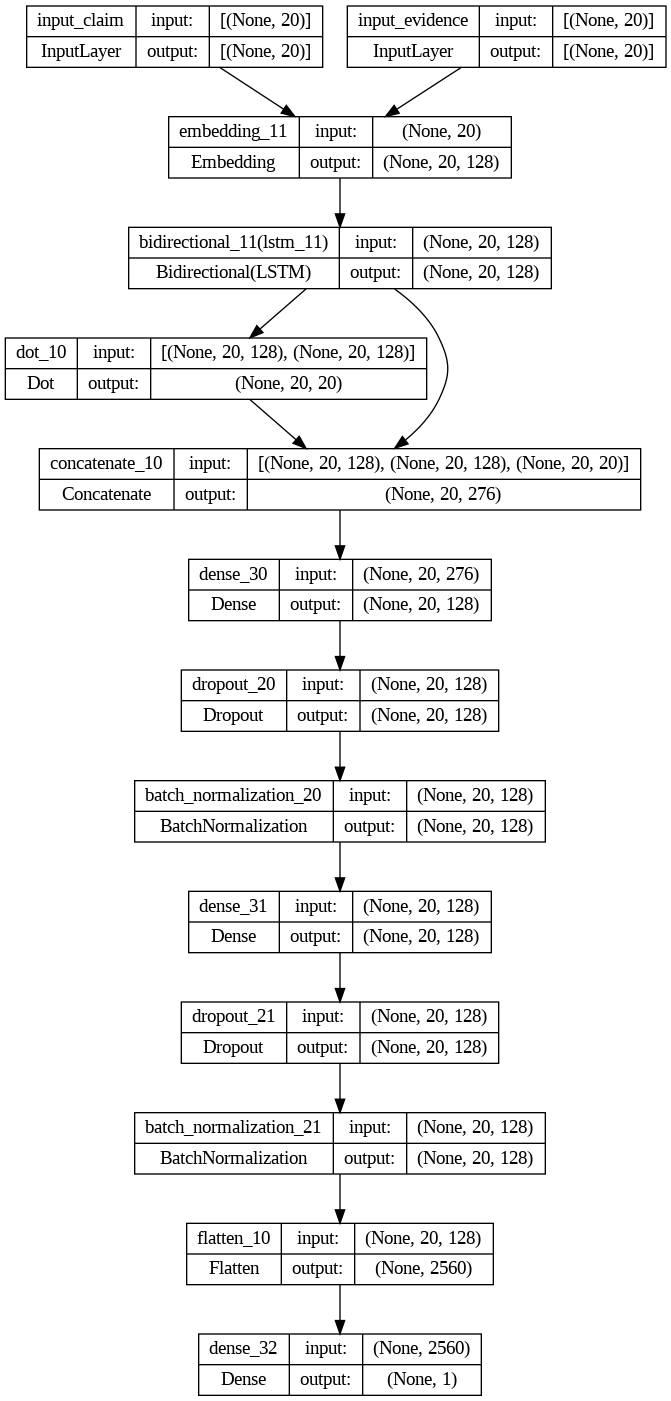

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define constants
embedding_dim = 128
lstm_units = 64
batch_size = 128
patience = 3
base_lr = 1e-4
max_lr = 1e-2
margin = 1
epochs = 10

# Get the length of the training dataset
train_seq_length = len(train_claim_sequence)

# Create the cyclical learning rate scheduler
clr = make_cyclical_lr(train_seq_length, batch_size, base_lr, max_lr)

# Build Siamese network model
siamese_model = build_siamese_network(max_length, vocab_size, embedding_dim, lstm_units)

# Compile the model
siamese_model.compile(optimizer=Adam(learning_rate=clr), loss=loss(margin), metrics=['acc'])

# Stop the training when there is no improvement in the val_loss for three consecutive epochs
callback = EarlyStopping(patience=patience)

# Print model summary
siamese_model.summary()
tf.keras.utils.plot_model(siamese_model, to_file='output/siamese_model.png', show_shapes=True, expand_nested=True)

Let's train the model on the training data.

In [ ]:
# Train the model
siamese_history = siamese_model.fit([train_claim_sequence, train_evidence_sequence], train_labels.reshape(-1, 1), epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[callback])

Epoch 1/10
307/307 [==============================] - 57s 162ms/step - loss: 0.0763 - acc: 0.9064 - val_loss: 0.0355 - val_acc: 0.9585
Epoch 2/10
307/307 [==============================] - 40s 131ms/step - loss: 0.0359 - acc: 0.9591 - val_loss: 0.0689 - val_acc: 0.9226
Epoch 3/10
307/307 [==============================] - 37s 120ms/step - loss: 0.0316 - acc: 0.9646 - val_loss: 0.0404 - val_acc: 0.9555
Epoch 4/10
307/307 [==============================] - 37s 122ms/step - loss: 0.0310 - acc: 0.9659 - val_loss: 0.0384 - val_acc: 0.9585


### Making Predictions
Now that we have trained our model on the training set, it's time to make predictions on both the train (used for training the classification model later) and dev claims. For this we will use a top-k method based on predicted probabilities. If the predicted probability of an evidence being relevant is among the top-k highest predicted probabilities, we accept that evidence as being relevant.

Thus, we extract $\text{min(number of available evidences, }k)$ evidences per claim.

In [ ]:
def predict_relevant_evidences(model, claims_data, evidence_data, k=3, name=''):
    """
    Predicts relevant evidences for claims based on the top k probabilities.

    Args:
    model (tensorflow.keras.models.Model): Trained evidence retrieval model.
    claims_data (dict): Dictionary containing claim data.
    evidence_data (dict): Dictionary containing evidence data.
    k (int): Number of top evidences to store per claim. Defaults to 3.
    name (str): Name of the claims data. Defaults to empty string.

    Returns:
    dict: Predicted relevant evidences for each claim in the format {claim_id: {padded_sequence: original_padded_sequence, evidences: [list of predicted relevant evidences], claim_label: original_label}}.
    """
    predicted_data = {}

    # Retrieve all the evidence ids and padded sequences
    evidence_keys = list(evidence_data.keys())
    evidence_sequences = np.array([evidence_data[id]['padded_sequence'] for id in evidence_keys])
    num_evidences = len(evidence_keys)

    # Iterate over claims data
    for claim_id, claim_info in tqdm(claims_data.items(), desc=f'Predicting over {name}'):
        claim_sequence = claim_info['padded_sequence']
        claim_sequence_for_prediction = np.tile(claim_sequence, (num_evidences, 1))

        # Get the predicted probabilities from the model for current claim and all evidences
        predicted_probs = model.predict([claim_sequence_for_prediction, evidence_sequences], batch_size=1024, verbose=0)

        # Create a list of evidence indices and probabilities
        evidence_indices_with_probs = list(enumerate(predicted_probs))

        # Sort evidences by probability in descending order
        evidence_indices_with_probs.sort(key=lambda x: x[1], reverse=True)

        # Select the top k evidences
        top_k_evidence_indices = [evidence_indices_with_probs[i][0] for i in range(min(k, len(evidence_indices_with_probs)))]

        # Retrieve evidence ids for the top k evidences
        predicted_evidences = [evidence_keys[idx] for idx in top_k_evidence_indices]

        # Store predicted data for each claim
        predicted_data[claim_id] = {
            'padded_sequence': claim_sequence.tolist(),
            'evidences': predicted_evidences,
            'claim_label': claim_info['claim_label']  # Include original label
        }

    return predicted_data


Let's now make predictions on the data. For this we will use a top-k value such that we get the best F-Score for evidence retrieval.

In [ ]:
# Fix top-k evidences to retrieve
top_k = 5

# Predict relevant evidences for train_claims
train_predicted_data = predict_relevant_evidences(siamese_model, train_claims, evidence, k=top_k, name='train_claims')

# Predict relevant evidences for dev_claims
dev_predicted_data = predict_relevant_evidences(siamese_model, dev_claims, evidence, k=top_k, name='dev_claims')

Predicting over dev_claims: 100%|██████████| 154/154 [01:02<00:00,  2.47it/s]


### Saving the Outputs
As can be seen from the execution history above, the whole preparing datasets for training and training the model itself takes quite a long time. Hence, we will be saving the `train_predicted_data`, `dev_predicted_data` and `evidence` to an output folder so that they can be used directly in the next phases without having to re-run all the evidence-retrieval tasks every time.

In [ ]:
# Convert and write JSON object to file
with open('output/train_predicted_data.json', "w") as outfile:
    json.dump(train_predicted_data, outfile)

with open('output/dev_predicted_data.json', "w") as outfile:
    json.dump(dev_predicted_data, outfile)

# Convert evidence sequence into list and write JSON object to file
for id, info in tqdm(evidence.items()):
    sequence = info['padded_sequence'].tolist()
    evidence[id]['padded_sequence'] = sequence

with open('output/evidence.json', "w") as outfile:
    json.dump(evidence, outfile)

100%|██████████| 1208827/1208827 [00:07<00:00, 160331.55it/s]


## Label Classification Task
Now we wish to to perform the following task: for a given claim and a list of relevant evidences, predict whether the evidences supports, refutes or disputes the claim or if there's not enough information to make a prediction.

### Load the Dataset
First, let's load the dataset produced by the evidence retrieval model and convert the padded sequence into a numpy array as they were stored in as a list.

In [ ]:
# Load the datasets
train_predicted_data = load_data('output/train_predicted_data.json')
dev_predicted_data = load_data('output/dev_predicted_data.json')
evidence = load_data('output/evidence.json')

In [ ]:
import numpy as np
# Convert the padded_sequence into ndarray
for claims_id, claims_info in train_predicted_data.items():
    sequence = claims_info['padded_sequence']
    train_predicted_data[claims_id]['padded_sequence'] = np.array(sequence)

for claims_id, claims_info in dev_predicted_data.items():
    sequence = claims_info['padded_sequence']
    dev_predicted_data[claims_id]['padded_sequence'] = np.array(sequence)

for evidence_id, evidence_info in evidence.items():
    sequence = evidence_info['padded_sequence']
    evidence[evidence_id]['padded_sequence'] = np.array(sequence)

### Prepare Training Data
Now let's prepare the training data by creating a 3D features array where each element is a 2D numpy array consisiting of the claim sequence and all its relevant evidence sequences. The final shape of the features array should be [number of claims, k + 1, max_length].

For the labels, we will transform them into integers using the LabelEncoder() module of scikit-learn.

In [ ]:
def prepare_transformer_training_data(claims_data, evidence_data):
    """
    Prepares training data for a Transformer-based classifier model by combining claim sequences with predicted relevant evidence sequences.

    Args:
    claims_data (dict): Dictionary containing claim data.
    evidence_data (dict): Dictionary containing evidence data.

    Returns:
    tuple: Combined sequences of claim texts and predicted evidence texts, and labels corresponding to the combined sequences.

    """
    # Initialize empty lists for combined sequences and labels
    combined_sequences = []
    train_labels = []

    # Iterate over each claim in the claims_data dictionary
    for claim_id, claim_info in tqdm(claims_data.items(), desc='Processing data'):
        claim_sequence = claim_info['padded_sequence']  # Padded sequence of claim text
        evidences = claim_info['evidences']  # List of predicted evidence ids

        # Collect the padded sequences of predicted evidences for the claim
        evidence_sequences = [evidence_data[eid]['padded_sequence'] for eid in evidences]

        # Reshape claim_sequence to a 2D array (row vector)
        claim_sequence_2d = claim_sequence[np.newaxis, :]

        # Reshape each evidence_sequence to a 2D array (row vector)
        evidence_sequences_2d = [e_seq[np.newaxis, :] for e_seq in evidence_sequences]

        # Concatenate claim_sequence_2d with all evidence_sequences_2d along axis 0
        concatenated_sequence = np.concatenate([claim_sequence_2d] + evidence_sequences_2d, axis=0)

        # Append the concatenated sequence to the list of combined_sequences
        combined_sequences.append(concatenated_sequence)

        # Append the label of the claim to the list of train_labels
        train_labels.append(claim_info['claim_label'])

    # Convert lists to numpy arrays
    combined_sequences = np.array(combined_sequences)
    train_labels = np.array(train_labels)

    return combined_sequences, train_labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Prepare the training data
combined_train_sequences, train_labels = prepare_transformer_training_data(train_predicted_data, evidence)

# Use LabelEncoder to convert string labels to integer labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

Processing data: 100%|██████████| 1228/1228 [00:00<00:00, 53193.90it/s]


Check the shapes of the arrays.

In [ ]:
print(combined_train_sequences.shape)
print(train_labels_encoded.shape)

(1228, 6, 20)
(1228,)


### Transformer-Encoder Network
For the classification task we will be using a Transformer-Encoder model that will be built from scratch.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling2D, Embedding, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    """
    Custom layer implementing a single Transformer Encoder Layer.

    Parameters:
        embedding_dim (int): Dimensionality of the embedding.
        num_heads (int): Number of attention heads.
        ff_dim (int): Number of units in the feed-forward network.
        dropout_rate (float): Dropout rate.
    """
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        # Multi-head self-attention layer
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        # Feed-forward network (2 dense layers with ReLU activation)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embedding_dim)
        ])

        # Layer normalization layers after attention and feed-forward network
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        # Dropout layers for regularization
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        """
        Forward pass of the layer.

        Args:
            inputs (tf.Tensor): Input tensor.
            training (bool): Whether the model is in training mode.

        Returns:
            tf.Tensor: Output tensor.
        """
        # Multi-head self-attention
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection and layer normalization

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection and layer normalization

        return out2

class TransformerEncoder(tf.keras.layers.Layer):
    """
    Custom layer implementing a Transformer Encoder.

    Parameters:
        num_layers (int): Number of encoder layers.
        embedding_dim (int): Dimensionality of the embedding.
        num_heads (int): Number of attention heads.
        ff_dim (int): Number of units in the feed-forward network.
        input_vocab_size (int): Size of the input vocabulary.
        maximum_position_encoding (int): Maximum length of position encoding.
        dropout_rate (float): Dropout rate.
    """
    def __init__(self, num_layers, embedding_dim, num_heads, ff_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # Embedding layer to convert token indices to embeddings
        self.embedding = Embedding(input_vocab_size, embedding_dim, mask_zero=True)

        # Positional encoding for handling sequence order
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, embedding_dim)

        # List of TransformerEncoderLayer instances (to stack multiple encoder layers)
        self.enc_layers = [TransformerEncoderLayer(embedding_dim, num_heads, ff_dim, dropout_rate)
                           for _ in range(num_layers)]

        # Dropout layer for regularization
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training):
        """
        Forward pass of the layer.

        Args:
            inputs (tf.Tensor): Input tensor.
            training (bool): Whether the model is in training mode.

        Returns:
            tf.Tensor: Output tensor.
        """
        seq_len = tf.shape(inputs)[2]

        # Convert input token indices to embeddings
        x = self.embedding(inputs)

        # Scale embeddings by sqrt(embedding_dim) to stabilize gradients
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add positional encoding to embeddings to capture sequence order
        x += self.pos_encoding[:, :seq_len, :]  # Broadcasting pos_encoding to match the shape of x

        # Apply dropout for regularization
        x = self.dropout(x, training=training)

        # Pass input through each TransformerEncoderLayer in sequence
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)

        return x

    def positional_encoding(self, position, embedding_dim):
        """
        Function to create positional encodings.

        Args:
            position (int): Maximum position for the positional encoding.
            embedding_dim (int): Dimensionality of the embedding dimension.

        Returns:
            tf.Tensor: Positional encodings of shape (1, position, embedding_dim).
        """
        # Compute angles for positional encodings
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(embedding_dim)[np.newaxis, :] // 2)) / np.float32(embedding_dim))

        # Apply sine to even indices in the array (2i)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cosine to odd indices in the array (2i+1)
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        # Add batch dimension to positional encodings and cast to float32
        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

def build_transformer_classifier(num_layers, embedding_dim, num_heads, ff_dim, input_vocab_size, input_shape, maximum_position_encoding, dropout_rate, num_classes):
    """
    Build a Transformer-based classifier model for claim classification.

    Args:
        num_layers (int): Number of encoder layers.
        embedding_dim (int): Dimensionality of the embedding.
        num_heads (int): Number of attention heads.
        ff_dim (int): Number of units in the feed-forward network.
        input_vocab_size (int): Size of the input vocabulary.
        input_shape (tuple): Shape of input sequence.
        maximum_position_encoding (int): Maximum length of position encoding.
        dropout_rate (float): Dropout rate.
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Transformer-based classifier model.
    """
    inputs = Input(shape=input_shape)
    encoder = TransformerEncoder(num_layers, embedding_dim, num_heads, ff_dim, input_vocab_size, maximum_position_encoding, dropout_rate)
    encoder_output = encoder(inputs)

    # Global average pooling to reduce sequence dimensionality
    pooled_output = GlobalAveragePooling2D(keepdims=True)(encoder_output)

    # Flatten the outputs
    flatten = Flatten()(pooled_output)

    # Additional dense layers for classification
    outputs = Dense(num_classes, activation='softmax')(flatten)

    # Create and compile the model
    model = Model(inputs, outputs)

    return model

### Sparse Categorical Focal Loss
To fine tune our transformer model to be used for the task at hand, it is important to choose an appropriate loss function. Since our data is imbalanced, we will employ focal loss for this.

It is defined as:
$\text{focal loss} = -\frac{1}{N} \sum_{i=1}^{N} \left( \alpha (1 - p_i)^{\gamma} \log(p_i) \right)$, where,

- $N$: Number of samples
- $K$: Number of classes
- $y_i$: Integer class label (0 to $K-1$)
- $p_i$: Model's predicted probabilities (logits or probabilities, depending on the `from_logits` parameter)

In [ ]:
from collections import Counter

# Initialize an empty list to store labels
labels = []

# Iterate through items in train_predicted_data dictionary
for key, value in train_predicted_data.items():
    # Append the 'claim_label' value of each item to the labels list
    labels.append(value["claim_label"])

# Count occurrences of each label using Counter from collections
label_counts = Counter(labels)

# Print the count of each label
print(label_counts)

Counter({'SUPPORTS': 519, 'NOT_ENOUGH_INFO': 386, 'REFUTES': 199, 'DISPUTED': 124})


There is some degree of data imbalance in our dataset. In this case, the classes 'SUPPORTS' and 'NOT_ENOUGH_INFO' are overrepresented, while 'REFUTES' and 'DISPUTED' are underrepresented.

In [ ]:
from tensorflow.keras.losses import Loss

class CustomFocalLoss(Loss):
    def __init__(self, alpha=0.25, gamma=2.0, num_classes=4, reduction=tf.keras.losses.Reduction.AUTO):
        """
        Initializes the CustomFocalLoss.

        Parameters:
        - alpha: Weighting factor for the rare class (default is 0.25)
        - gamma: Exponent of the modulating factor (default is 2.0)
        - num_classes: Number of classes in the classification task (default is 4)
        - reduction: Type of reduction to apply to the loss (default is AUTO)
        """
        super(CustomFocalLoss, self).__init__(reduction=reduction)
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes

    def call(self, y_true, y_pred):
        """
        Computes the focal loss.

        Parameters:
        - y_true: True labels (ground truth)
        - y_pred: Predicted labels (predicted probabilities)

        Returns:
        - Focal loss value
        """
        # Compute categorical cross-entropy loss
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)  # Calculate categorical cross-entropy
        p_t = tf.exp(-ce_loss)  # Compute predicted probabilities
        # Calculate focal loss using the defined formula
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss

        return focal_loss

### Compiling the Model
Now that the model and the custom loss function are defined, we may compile the transformer model.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 20)]           0         
                                                                 
 transformer_encoder_1 (Tra  (None, 6, 20, 128)        72861824  
 nsformerEncoder)                                                
                                                                 
 global_average_pooling2d_1  (None, 1, 1, 128)         0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 4)                 516       
                                                                 
Total params: 72862340 (277.95 MB)
Trainable params: 728623

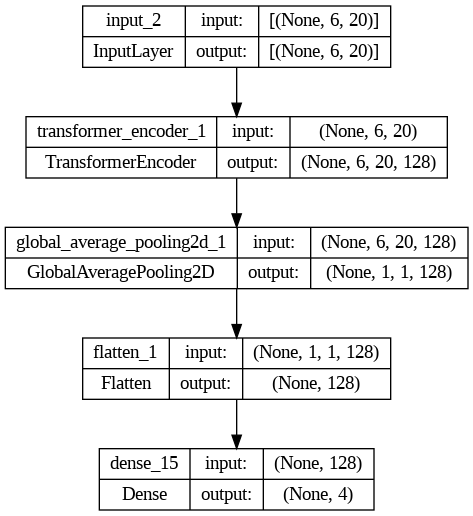

In [ ]:
# Parameters for the Transformer-Encoder
num_layers = 3  # Number of Transformer Encoder layers
embedding_dim = 128  # Embedding dimension for output
num_heads = 8  # Number of attention heads
ff_dim = 128  # Feed-forward dimension
dropout_rate = 0.2 # Dropout rate

input_vocab_size = vocab_size # Size of the input vocabulary
input_shape = (combined_train_sequences.shape[1], combined_train_sequences.shape[2]) # Shape of the input sequence.
maximum_position_encoding = max_length # Maximum length of position encoding
num_classes = 4  # Number of output classes


# Build and compile the Transformer-Encoder model
transformer_encoder = build_transformer_classifier(num_layers, embedding_dim,
                                                   num_heads, ff_dim, input_vocab_size,
                                                   input_shape, maximum_position_encoding,
                                                   dropout_rate, num_classes)

transformer_encoder.compile(optimizer=Adam(learning_rate=1e-4),
                            loss=CustomFocalLoss(alpha=0.25, gamma=2.0, num_classes=4),
                            metrics=['acc'])


# Print the summary of the model
transformer_encoder.summary()

tf.keras.utils.plot_model(transformer_encoder,
                          to_file='output/transformer_encoder_CustomFocalLoss.png',
                          show_shapes=True, expand_nested=True)

### Training on Train Dataset
With the model compiled and the training dataset ready, we may train the model on this data. We will also use early stopping to prevent overfitting and set `restore_best_weights = True` to get the best fitted weights.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define constants
batch_size = 32
epochs = 10


# Define early stopping
early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

# Train the model with early stopping
transformer_history = transformer_encoder.fit(combined_train_sequences, train_labels_encoded.reshape(-1, 1), batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/10
31/31 [==============================] - 19s 205ms/step - loss: 0.1867 - acc: 0.3727 - val_loss: 0.2039 - val_acc: 0.2967
Epoch 2/10
31/31 [==============================] - 6s 181ms/step - loss: 0.1770 - acc: 0.4053 - val_loss: 0.1643 - val_acc: 0.4675
Epoch 3/10
31/31 [==============================] - 4s 136ms/step - loss: 0.1693 - acc: 0.4134 - val_loss: 0.1616 - val_acc: 0.4593
Epoch 4/10
31/31 [==============================] - 4s 129ms/step - loss: 0.1687 - acc: 0.4267 - val_loss: 0.1689 - val_acc: 0.3455
Epoch 5/10
31/31 [==============================] - 5s 156ms/step - loss: 0.1676 - acc: 0.4481 - val_loss: 0.1601 - val_acc: 0.4756
Epoch 6/10
31/31 [==============================] - 3s 114ms/step - loss: 0.1581 - acc: 0.5041 - val_loss: 0.1597 - val_acc: 0.4756
Epoch 7/10
31/31 [==============================] - 3s 110ms/step - loss: 0.1492 - acc: 0.5509 - val_loss: 0.1617 - val_acc: 0.5000
Epoch 8/10
31/31 [==============================] - 3s 93ms/step - loss: 0.

### Making Predictions on Dev Dataset
With the model now trained, we can make predictions on the dev dataset and see how the model performs.

In [ ]:
def get_classification_predictions(model, label_encoder, claims_data, evidence_data):
    """
    Generate classification predictions for given claims and evidence using a trained model.

    Args:
        model (keras.Model): The trained classification model.
        label_encoder (LabelEncoder): The label encoder used to encode true labels.
        claims_data (dict): Dictionary of claim text.
        evidence_data (dict): Dictionary of evidence text.

    Returns:
        tuple: A tuple containing true labels (list) and predicted labels (list).
    """
    # Prepare combined sequences and true labels
    combined_sequences, true_labels = prepare_transformer_training_data(claims_data, evidence_data)

    # Encode true labels
    true_labels_encoded = label_encoder.transform(true_labels)

    # Predict class probabilities
    class_probabilities = model.predict(combined_sequences)

    # Convert predicted probabilities to class labels
    predicted_labels = [np.argmax(prob) for prob in class_probabilities]

    return true_labels_encoded, predicted_labels

In [ ]:
# Get the true and predicted labels
true_dev_labels, predicted_dev_labels = get_classification_predictions(transformer_encoder, label_encoder, dev_predicted_data, evidence)

Processing data: 100%|██████████| 154/154 [00:00<00:00, 34924.19it/s]


5/5 [==============================] - 1s 33ms/step


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Metrics for Evidence Retrieval

### Precision, Recall and F1-Score
Since the data was imbalanced (more irrelevant evidences), mere accuracy will not give a clear picture of the performance of the Siamese model. Hence, we should check the precision, recall and F1-scores.

In [ ]:
def calculate_siamese_metrics(predicted_data, claims_data):
    """
    Calculates precision, recall, and F-score for the predicted data.

    Args:
    predicted_data (dict): Predicted relevant evidences for each claim.
    claims_data (dict): Dictionary containing claim data including true evidences.

    Returns:
    tuple: Mean precision, recall and F score.
    """
    precision_scores = []
    recall_scores = []

    for claim_id, claim_info in predicted_data.items():
        true_evidences = set(claims_data[claim_id]['evidences'])
        predicted_evidences = set(claim_info['evidences'])

        # Calculate precision
        common_evidences = true_evidences.intersection(predicted_evidences)
        precision = len(common_evidences) / len(predicted_evidences) if len(predicted_evidences) > 0 else 0
        precision_scores.append(precision)

        # Calculate recall
        recall = len(common_evidences) / len(true_evidences) if len(true_evidences) > 0 else 0
        recall_scores.append(recall)

    # Calculate mean precision and recall
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)

    # Calculate F-score
    f_score = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall) if mean_precision + mean_recall > 0 else 0

    return mean_precision, mean_recall, f_score

In [ ]:
# Calculate metrics for train_predicted_data
train_metrics = calculate_siamese_metrics(train_predicted_data, train_claims)

# Calculate metrics for dev_predicted_data
dev_metrics = calculate_siamese_metrics(dev_predicted_data, dev_claims)

print("Metrics for train_predicted_data:")
print(f"precision = {round(train_metrics[0], 3)}; recall = {round(train_metrics[1], 3)}; F-score = {round(train_metrics[2], 3)}")
print("Metrics for dev_predicted_data:")
print(f"precision = {round(dev_metrics[0], 3)}; recall = {round(dev_metrics[1], 3)}; F-score = {round(dev_metrics[2], 3)}")

Metrics for train_predicted_data:
precision = 0.551; recall = 0.866; F-score = 0.673
Metrics for dev_predicted_data:
precision = 0.534; recall = 0.883; F-score = 0.665


## Metrics for Claim Classification

### Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score
# Print the accuracy score
print("Accuracy: ", accuracy_score(true_dev_labels, predicted_dev_labels))

Accuracy:  0.487012987012987


### Classification Report

In [ ]:
# Convert integer labels to string
true_dev_labels_str = label_encoder.inverse_transform(true_dev_labels)
predicted_dev_labels_str = label_encoder.inverse_transform(predicted_dev_labels)

# Get counts of each label
print(f'True Label Counts: {np.array(np.unique(true_dev_labels_str, return_counts=True))}')
print(f'Predicted Label Counts: {np.array(np.unique(predicted_dev_labels_str, return_counts=True))}')

True Label Counts: [['DISPUTED' 'NOT_ENOUGH_INFO' 'REFUTES' 'SUPPORTS']
 ['18' '41' '27' '68']]
Predicted Label Counts: [['NOT_ENOUGH_INFO' 'SUPPORTS']
 ['42' '112']]


In [ ]:
from sklearn.metrics import classification_report
# Get classfication report to evaluate each label
print("Classification Report:")
print(classification_report(true_dev_labels_str, predicted_dev_labels_str, zero_division=0.0))

Classification Report:
                 precision    recall  f1-score   support

       DISPUTED       0.00      0.00      0.00        18
NOT_ENOUGH_INFO       0.43      0.44      0.43        41
        REFUTES       0.00      0.00      0.00        27
       SUPPORTS       0.51      0.84      0.63        68

       accuracy                           0.49       154
      macro avg       0.23      0.32      0.27       154
   weighted avg       0.34      0.49      0.40       154



### Accuracy and Loss Performance across the Epochs

max train accuracy: 0.6466395258903503
max val_acc: 0.5
maxtrain loss: 0.18671193718910217
max val_loss: 0.2712700068950653


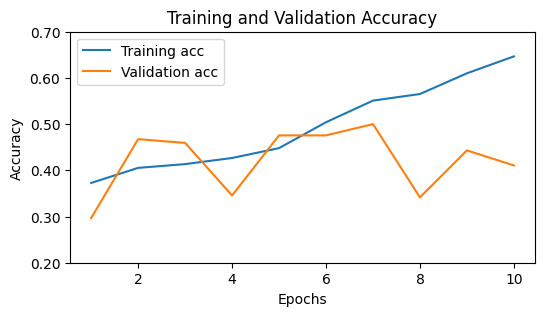

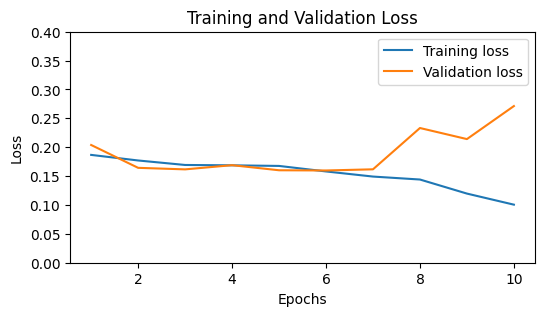

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Extract data from the transformer_history object
acc = transformer_history.history['acc']
val_acc = transformer_history.history['val_acc']
loss = transformer_history.history['loss']
val_loss = transformer_history.history['val_loss']
epochs = range(1, len(acc) + 1)

print("max train accuracy:", max(acc))
print("max val_acc:", max(val_acc))
print("maxtrain loss:", max(loss))
print("max val_loss:", max(val_loss))

# Plotting the accuracy over epochs
plt.figure(figsize=(6, 3))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.ylim([0.2, 0.7])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the loss over epochs
plt.figure(figsize=(6, 3))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.ylim([0, 0.4])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Get Final Outputs and Evaluate Overall Results
With the training and predictions now complete, we may output the final results, and use the given `eval.py` script to evaluate the final overall performance of the models.

In [ ]:
# Initialize an empty dictionary to store final output for development data
final_dev_output = dict()

# Initialize an index counter to keep track of the position in predicted_dev_labels_str
index_count = 0

# Iterate over each claim_id in dev_predicted_data
for claim_id in dev_predicted_data:
    # Get the predicted label from predicted_dev_labels_str using the current index
    predicted_label = predicted_dev_labels_str[index_count]

    # Populate final_dev_output dictionary with relevant data
    final_dev_output[claim_id] = {
        'evidences': dev_predicted_data[claim_id]['evidences'],  # Copy evidences from dev_predicted_data
        'claim_label': predicted_label  # Assign predicted label to 'claim_label' field
    }

    # Increment index_count to move to the next predicted label
    index_count += 1

# Write final_dev_output dictionary to a JSON file
with open('output/final_dev_output.json', 'w') as outfile:
    json.dump(final_dev_output, outfile)

In [ ]:
# Call eval.py with the predicted and ground-truth data
!python3 eval.py --predictions output/final_dev_output.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.622253143681715
Claim Classification Accuracy (A) = 0.487012987012987
Harmonic Mean of F and A          = 0.5463889211020347


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*